## Approach:

We see the given problem as binomial logistic regression. We need to predict whether the user will click the ad impression or not. Based on **Viewlog and item log**, we build the **user profile** with the following attributes.


- user_id                      
- total_search_count           : Number of searches the user has done on Zbay     
- no_of_sessions               : Number of times user has logged onto Zbay.
- no_of_unique_items           : Number of Unique items that the user has searched.
- frequent_item                : Frequent item that the user has searched for 
- frequent_item_search_count   : Number of times the user has searched his/her recent item
- recent_device                : recent device user has user for last login
- recent_item_searched         : recent item that the user has searched for
- recent_search_time           : recent search time 
- freq_item_price              : price of frequent item that the user has searched for 
- freq_prod_type               : Product type of the frequent ite
- freq_item_length             : Length derived as category1+category2+category3 
- freq_no_of_items             : Number of items in the product type of the product 
- freq_prod_length             : Product type length of the frequent item 
- freq_max_price               : Max Price for product type of the frequent item 
- freq_min_price               : Min Price for product type of the frequent item
- rec_item_price               : Recent item price 
- rec_prod_type                : Product type of the recent item 
- rec_item_length              : item length of the recent item 
- rec_no_of_items              : number of items in product type of the recent item 
- rec_prod_length              : Lenght of product type of the recent item 
- rec_max_price                : Max Price for product type of the recent item  
- rec_min_price                : Min Price for product type of the recent item  

We enrich the **Impression data** with the above user profile(based on user id) and build a logistic regression using the resultant data set.


We also derive the following attributes using impression data.

- ad_rn : Corresponding rank of the impression ( like 1st ad, 2nd ad, ... nth ad)

In [211]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import imblearn as im;

**Read the data**

In [212]:
tr1=pd.read_csv("train.csv")
view_log=pd.read_csv("view_log.csv")
item_data=pd.read_csv("item_data.csv")

ts1=pd.read_csv("test.csv")

**View the data**

In [213]:
tr1.head(5)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [214]:
view_log.head(5)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [215]:
ts1['is_click'] = 0;

In [216]:
ts1['test_train'] = 'test';
tr1['test_train'] = 'train';

In [217]:
tr = tr1;

 We keep the training and test data in the same dataframe for easy handling. The field 'test_train' identifies whether the data set is training or for testing.

In [218]:
tr1= pd.concat([tr1, ts1])

In [219]:
tr1[tr1.test_train=='train'].count()

impression_id      237609
impression_time    237609
user_id            237609
app_code           237609
os_version         237609
is_4G              237609
is_click           237609
test_train         237609
dtype: int64

In [220]:
tr1[tr1.test_train=='test'].count()

impression_id      90675
impression_time    90675
user_id            90675
app_code           90675
os_version         90675
is_4G              90675
is_click           90675
test_train         90675
dtype: int64

## Summarize ViewLog

In [221]:
view_summary = view_log.groupby(['user_id']).size().reset_index(name='total_search_count');

In [222]:
## Number of sessions per user

x = (view_log
    .groupby(['user_id'])
    .session_id
    .nunique()
    .reset_index(name='no_of_sessions') # number of sessions per user
    )

view_summary=pd.merge(view_summary, x, how='inner', on='user_id');

In [223]:
## Number of unique items user has searched

x = (view_log
    .groupby(['user_id'])
    .item_id
    .nunique()
    .reset_index(name='no_of_unique_items')
    )

view_summary=pd.merge(view_summary, x, how='inner', on='user_id');

In [224]:
## Most frequently searched item and its searh count

x = ( view_log
    .groupby(['user_id','item_id'])
    .session_id
    .count()    ## number of items a product has been searched
    .reset_index(name='item_search_count')
    .sort_values('item_search_count')  # sort to get most searched item
    .groupby(['user_id'])
    .tail(1))

x.rename(columns={'item_id':'frequent_item'}, inplace=True)
x.rename(columns={'item_search_count':'frequent_item_search_count'}, inplace=True)

view_summary=pd.merge(view_summary, x, how='inner', on='user_id');

In [225]:
## Recently searched item, and other factors

x = (view_log
    .sort_values('server_time')
    .groupby(['user_id'])
    .tail(1))

x.rename(columns = {'item_id':'recent_item_searched'}, inplace=True)
x.rename(columns = {'device_type':'recent_device'}, inplace=True)
x.rename(columns = {'server_time':'recent_search_time'}, inplace=True)

x = x[['user_id','recent_device','recent_item_searched','recent_search_time']]

view_summary=pd.merge(view_summary, x, how='inner', on='user_id');

view_summary.head()

,user_id,total_search_count,no_of_sessions,no_of_unique_items,frequent_item,frequent_item_search_count,recent_device,recent_item_searched,recent_search_time
0,0,42,11,18,44459,6,android,66401,2018-12-07 20:32:00
1,1,8,3,8,126431,1,android,6615,2018-12-09 01:37:00
2,2,165,37,130,127236,6,android,97362,2018-12-09 19:28:00
3,3,8,1,3,3942,3,android,26074,2018-10-19 16:03:00
4,4,2,1,2,38231,1,android,38231,2018-12-07 23:20:00


## Summarize Item_Data

In [226]:
item_data.head(5)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [227]:
item_data['item_length'] =  item_data.category_1 + item_data.category_2 + item_data.category_3;

In [228]:
product_summary = item_data.groupby('product_type', as_index=False).agg({
    'item_id':'count',
    'item_length': 'sum',
    'item_price': ['max','min']
})

product_summary.columns =['product_type', 'no_of_items_in_prod_type', 'prod_length', 'prod_type_max_price', 'prod_type_min_price']

In [229]:
product_summary.head()

,product_type,no_of_items_in_prod_type,prod_length,prod_type_max_price,prod_type_min_price
0,0,11,2387,3476,375
1,2,5,452,104960,4550
2,3,12,2604,35712,2368
3,5,3,924,9043,1881
4,6,88,27460,22336,889


In [230]:
item_summary=pd.merge(item_data, product_summary, how='inner', on='product_type')

In [231]:
item_summary.head()

,item_id,item_price,category_1,category_2,category_3,product_type,item_length,no_of_items_in_prod_type,prod_length,prod_type_max_price,prod_type_min_price
0,26880,4602,11,35,20,3040,66,9,978,4602,1843
1,51564,2592,11,35,20,3040,66,9,978,4602,1843
2,130031,3450,11,35,20,3040,66,9,978,4602,1843
3,694,1843,11,35,148,3040,194,9,978,4602,1843
4,8939,3450,11,35,20,3040,66,9,978,4602,1843


## User Profile based on View_summary, item_summary

In [232]:
view_summary.head()

,user_id,total_search_count,no_of_sessions,no_of_unique_items,frequent_item,frequent_item_search_count,recent_device,recent_item_searched,recent_search_time
0,0,42,11,18,44459,6,android,66401,2018-12-07 20:32:00
1,1,8,3,8,126431,1,android,6615,2018-12-09 01:37:00
2,2,165,37,130,127236,6,android,97362,2018-12-09 19:28:00
3,3,8,1,3,3942,3,android,26074,2018-10-19 16:03:00
4,4,2,1,2,38231,1,android,38231,2018-12-07 23:20:00


In [233]:
item_summary.head()

,item_id,item_price,category_1,category_2,category_3,product_type,item_length,no_of_items_in_prod_type,prod_length,prod_type_max_price,prod_type_min_price
0,26880,4602,11,35,20,3040,66,9,978,4602,1843
1,51564,2592,11,35,20,3040,66,9,978,4602,1843
2,130031,3450,11,35,20,3040,66,9,978,4602,1843
3,694,1843,11,35,148,3040,194,9,978,4602,1843
4,8939,3450,11,35,20,3040,66,9,978,4602,1843


In [234]:
x = item_summary[['item_id','item_price','product_type',
                  'item_length','no_of_items_in_prod_type',
                  'prod_length','prod_type_max_price','prod_type_min_price']]

x.columns =['frequent_item','freq_item_price','freq_prod_type',
            'freq_item_length','freq_no_of_items',
           'freq_prod_length', 'freq_max_price','freq_min_price']

In [235]:
user_data = pd.merge(view_summary, x,  how='left', on = 'frequent_item')

In [236]:
user_data.head()

,user_id,total_search_count,no_of_sessions,no_of_unique_items,frequent_item,frequent_item_search_count,recent_device,recent_item_searched,recent_search_time,freq_item_price,freq_prod_type,freq_item_length,freq_no_of_items,freq_prod_length,freq_max_price,freq_min_price
0,0,42,11,18,44459,6,android,66401,2018-12-07 20:32:00,3776.0,7363.0,242.0,62.0,21129.0,12288.0,736.0
1,1,8,3,8,126431,1,android,6615,2018-12-09 01:37:00,3238.0,4552.0,283.0,25.0,7075.0,5597.0,1088.0
2,2,165,37,130,127236,6,android,97362,2018-12-09 19:28:00,15557.0,8127.0,276.0,251.0,68748.0,22092.0,375.0
3,3,8,1,3,3942,3,android,26074,2018-10-19 16:03:00,2355.0,491.0,188.0,220.0,41339.0,3833.0,102.0
4,4,2,1,2,38231,1,android,38231,2018-12-07 23:20:00,1977.0,4426.0,234.0,59.0,13806.0,2880.0,576.0


In [237]:
y = item_summary[['item_id','item_price','product_type',
                  'item_length','no_of_items_in_prod_type',
                  'prod_length','prod_type_max_price','prod_type_min_price']]

y.columns =['recent_item_searched','rec_item_price','rec_prod_type',
            'rec_item_length','rec_no_of_items',
           'rec_prod_length', 'rec_max_price','rec_min_price']

In [238]:
user_data = pd.merge(user_data, y,  how='left', on = 'recent_item_searched')

In [239]:
user_data.head()

,user_id,total_search_count,no_of_sessions,no_of_unique_items,frequent_item,frequent_item_search_count,recent_device,recent_item_searched,recent_search_time,freq_item_price,...,freq_prod_length,freq_max_price,freq_min_price,rec_item_price,rec_prod_type,rec_item_length,rec_no_of_items,rec_prod_length,rec_max_price,rec_min_price
0,0,42,11,18,44459,6,android,66401,2018-12-07 20:32:00,3776.0,...,21129.0,12288.0,736.0,1152.0,10457.0,242.0,67.0,16214.0,2816.0,960.0
1,1,8,3,8,126431,1,android,6615,2018-12-09 01:37:00,3238.0,...,7075.0,5597.0,1088.0,2412.0,10112.0,225.0,21.0,4734.0,3110.0,441.0
2,2,165,37,130,127236,6,android,97362,2018-12-09 19:28:00,15557.0,...,68748.0,22092.0,375.0,1240.0,7632.0,104.0,255.0,26520.0,10771.0,517.0
3,3,8,1,3,3942,3,android,26074,2018-10-19 16:03:00,2355.0,...,41339.0,3833.0,102.0,537.0,4805.0,56.0,4.0,224.0,768.0,537.0
4,4,2,1,2,38231,1,android,38231,2018-12-07 23:20:00,1977.0,...,13806.0,2880.0,576.0,1977.0,4426.0,234.0,59.0,13806.0,2880.0,576.0


In [240]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89157 entries, 0 to 89156
Data columns (total 23 columns):
user_id                       89157 non-null int64
total_search_count            89157 non-null int64
no_of_sessions                89157 non-null int64
no_of_unique_items            89157 non-null int64
frequent_item                 89157 non-null int64
frequent_item_search_count    89157 non-null int64
recent_device                 89157 non-null object
recent_item_searched          89157 non-null int64
recent_search_time            89157 non-null object
freq_item_price               89117 non-null float64
freq_prod_type                89117 non-null float64
freq_item_length              89117 non-null float64
freq_no_of_items              89117 non-null float64
freq_prod_length              89117 non-null float64
freq_max_price                89117 non-null float64
freq_min_price                89117 non-null float64
rec_item_price                89119 non-null float64
rec_pr

We notice that, there are a few columns which are of wrong data types. We convert them to the right data types.

In [242]:
user_data.frequent_item = user_data.frequent_item.astype('object') 

user_data.recent_item_searched = user_data.recent_item_searched.astype('object') 
user_data.freq_prod_type = user_data.freq_prod_type.astype('object') 
user_data.rec_prod_type  = user_data.rec_prod_type .astype('object') 

user_data.recent_search_time = pd.to_datetime(user_data.recent_search_time)


**Convert impression time to time format**

In [243]:
tr1.impression_time=pd.to_datetime(tr1.impression_time)

**Merge tables** - Understanding User Profile(what he viewed, what time etc)

In [245]:
#merge the item_view table with train and user_id as unique keys

tr_item =pd.merge(tr1, user_data, how='left',on='user_id')

#tr_item = tr_item.dropna();


tr_item["Time_To_ad"] = pd.to_numeric( (tr_item["impression_time"]
                                                  - tr_item["recent_search_time"]) /24/1000000000)

tr_item['Impr_Day'] = tr_item.impression_time.dt.dayofweek;
tr_item['Impr_Hour'] = tr_item.impression_time.dt.hour;

tr_item['rec_Day'] = tr_item.recent_search_time.dt.dayofweek;
tr_item['rec_Hour'] = tr_item.recent_search_time.dt.hour;


tr_item.app_code = tr_item.app_code.astype('object') ;
tr_item.Impr_Hour = tr_item.Impr_Hour.astype('object') ;
tr_item.Impr_Day = tr_item.Impr_Day.astype('object') ;

tr_item.rec_Hour = tr_item.rec_Hour.astype('object') ;
tr_item.rec_Day = tr_item.rec_Day.astype('object') ;

tr_item['ad_rn'] = (tr_item.sort_values(['impression_time'], ascending=[True]) 
             .groupby(['user_id']) 
             .cumcount() + 1)

X_features = list(tr_item.columns)

X_features.remove('impression_id');
X_features.remove('user_id');
X_features.remove('impression_time');

X_features.remove('is_click');

cols = tr_item.columns;

print("Unique column values")
for i in cols:
    print( i + '\t' +" :" + str(tr_item[i].unique().size))

Unique column values
impression_id	 :328284
impression_time	 :44783
user_id	 :89157
app_code	 :522
os_version	 :3
is_4G	 :2
is_click	 :2
test_train	 :2
total_search_count	 :555
no_of_sessions	 :156
no_of_unique_items	 :334
frequent_item	 :12252
frequent_item_search_count	 :78
recent_device	 :3
recent_item_searched	 :14108
recent_search_time	 :32194
freq_item_price	 :3900
freq_prod_type	 :3268
freq_item_length	 :227
freq_no_of_items	 :249
freq_prod_length	 :2407
freq_max_price	 :1777
freq_min_price	 :1164
rec_item_price	 :4262
rec_prod_type	 :3453
rec_item_length	 :226
rec_no_of_items	 :249
rec_prod_length	 :2480
rec_max_price	 :1860
rec_min_price	 :1206
Time_To_ad	 :81522
Impr_Day	 :7
Impr_Hour	 :24
rec_Day	 :7
rec_Hour	 :24
ad_rn	 :100


We observe that, some features(attributes) are highly correlated and use the following fields for model building.

In [246]:
X_features = ['app_code',
 'os_version',
 'is_4G',
 'total_search_count',
 #'no_of_sessions',
 #'no_of_unique_items',
 ##'frequent_item',
 'frequent_item_search_count',
 'recent_device',
 ##'recent_item_searched',
 #'recent_search_time',
 'freq_item_price',
 ##'freq_prod_type',
 'freq_item_length',
 'freq_no_of_items',
 'freq_prod_length',
 'freq_max_price',
 'freq_min_price',
 'rec_item_price',
 'rec_prod_type',
 'rec_item_length',
 'rec_no_of_items',
 'rec_prod_length',
 'rec_max_price',
 'rec_min_price',
 'Time_To_ad',
 'Impr_Day',
 'Impr_Hour',
 'rec_Day',
 'rec_Hour',
 'ad_rn',
 'test_train']

In [247]:
encoded_tr_item = pd.get_dummies(tr_item[X_features], drop_first=True);

In [248]:
encoded_tr_item.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328284 entries, 0 to 328283
Columns: 4052 entries, is_4G to test_train_train
dtypes: float64(12), int64(5), uint8(4035)
memory usage: 1.3 GB


In [249]:
X_train = encoded_tr_item[encoded_tr_item.test_train_train==1];

Y_train = pd.get_dummies(tr_item[tr_item.test_train=='train'][['is_click']],
                            drop_first = True); 

In [250]:
X_train.head()

,is_4G,total_search_count,frequent_item_search_count,freq_item_price,freq_item_length,freq_no_of_items,freq_prod_length,freq_max_price,freq_min_price,rec_item_price,...,rec_Hour_15,rec_Hour_16,rec_Hour_17,rec_Hour_18,rec_Hour_19,rec_Hour_20,rec_Hour_21,rec_Hour_22,rec_Hour_23,test_train_train
0,0,1,1,2350.0,66.0,1417.0,250598.0,31296.0,249.0,2350.0,...,0,0,0,1,0,0,0,0,0,1
1,1,12,5,3421.0,370.0,21.0,3514.0,25216.0,1693.0,1024.0,...,0,0,0,0,0,1,0,0,0,1
2,1,2,1,2224.0,168.0,39.0,6552.0,14359.0,900.0,2224.0,...,0,0,0,0,0,0,0,0,0,1
3,1,18,3,1601.0,234.0,136.0,31824.0,2407.0,449.0,18179.0,...,0,1,0,0,0,0,0,0,0,1
4,0,46,5,3686.0,304.0,302.0,72962.0,16992.0,115.0,2822.0,...,0,0,0,0,0,0,0,1,0,1


We create the below function for one variable regression. With one variable regression, we identify the variables which are siginificant or not. Later, we use them for final model building

In [251]:
import statsmodels.api as sm

def one_var_reg(X_train, Y_train):
    cols = [];
    for  col in X_train.columns:
        try:
            x_0 = sm.add_constant(X_train[col]);
            logit_0 = sm.Logit(Y_train, x_0);
            logit_model_0 = logit_0.fit();

            if (logit_model_0.pvalues[1] <= 0.05):  # get only the significant vriables
                cols.append([col,np.round(logit_model_0.pvalues[1],4)]);
        except Exception as e:
            pass;
    
    return  pd.DataFrame(cols,columns =["Variable", "p-val in one variable regression"])

In [163]:
one_var_reg_significance = one_var_reg(X_train,Y_train);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185634
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185522
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185649
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185677
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185670
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185661
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185667
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185657
         Iterations 7
         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.183255
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185666
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185644
         Iterations 7
         Current function value: 0.185680
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185657
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185301
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.184788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185672
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185656
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185666
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185390
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185613
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185600
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182247
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185670
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.185695
 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185669
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185618
         Iterations 7
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185632
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185550
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185596
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185664
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185675
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185684
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 9
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185671
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185678
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185669
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185661
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185666
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185673
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 9
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185685
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185669
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185670
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.185665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185664
         Iterations 7
         Current function value: 0.185695
         Iterations: 35
Optimization terminated successfully.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185675
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185637
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: inf
         Iterations: 35
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185665
         Iterations 9
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185669
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185675
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185696
         Iterations: 35
Optimization terminated successfully.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185670
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 16
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 8
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185685
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 8
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: inf
         Iterations: 35
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185676
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185685
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185682
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185624
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 16
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185685
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185666
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185679
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185675
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 9
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185695
         Iterations: 35
Optimization terminated successfully.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185659
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185671
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 9
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 9
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 16
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 9
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 8
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185670
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
         Current function value: 0.185677
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35
Optimization terminated successfully.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 8
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35
Optimization terminated successfully.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 8
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 9
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 29
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: inf
         Iterations: 35
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185684
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185670
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185689
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185687
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185690
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185688
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
         Current function value: 0.185680
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185690
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185683
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185685
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.185685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185692
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 30
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 21
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
         Current function value: 0.185691
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 7
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185679
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185686
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185694
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
         Current function value: 0.185693
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 20
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 29
         Current function value: 0.185695
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
         Current function value: 0.185696
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.185676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185687
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185691
  

In [165]:
one_var_reg_significance.sort_values('p-val in one variable regression')

,Variable,p-val in one variable regression
0,total_search_count,0.0000
112,rec_prod_type_631.0,0.0000
107,rec_prod_type_383.0,0.0000
100,rec_prod_type_3.0,0.0000
99,os_version_old,0.0000
98,os_version_latest,0.0000
95,app_code_508,0.0000
94,app_code_504,0.0000
92,app_code_469,0.0000
90,app_code_463,0.0000


In [166]:
 sig_vars = one_var_reg_significance;

In [253]:
 # sig_vars = pd.read_csv('Significant variables8.csv');

In [167]:
 sig_vars.to_csv('Significant variables8.csv');

In [254]:
X1 = sm.add_constant(X_train[sig_vars.Variable])

logit1 = sm.Logit(Y_train,X1);

logit1_model = logit1.fit();

logit1_model.summary2()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.169345
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit               Pseudo R-squared:    0.088     
Dependent Variable:     is_click            AIC:                 81297.8173
Date:                   2019-09-01 19:56    BIC:                 85563.3322
No. Observations:       237609              Log-Likelihood:      -40238.   
Df Model:               410                 LL-Null:             -44123.   
Df Residuals:           237198              LLR p-value:         0.0000    
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         9.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const                      -3.1143   0.0386 -80.7053 0.0000 -3.1899 -3.0386
total_search_count          0.0012   0.0002   7.4062 0.0000  0.0009  0.0016
frequent_item_search_count  0.0084   0.0018   4.6142 0.0000  0.0049  0.0120
Time_To_ad                 -0.0000   0.0000 -12.7300 0.0000 -0.0000 -0.0000
ad_rn                      -0.0073   0.0016  -4.5943 0.0000 -0.0104 -0.0042
app_code_3                 -0.2261   0.0632  -3.5755 0.0003 -0.3500 -0.1021
app_code_5                  0.4791   0.0584   8.1996 0.0000  0.3646  0.5936
app_code_8                  1.3487   0.4919   2.7419 0.0061  0.3846  2.3128
app_code_9                  0.3363   0.1581   2.1275 0.0334  0.0265  0.6460
app_code_14                 1.5247   0.2960   5.1518 0.0000  0.9446  2.1048
app_code_16                 0.8732   0.3039   2.8736 0.0041  0.2776  1.4688
app_code_28                 2.6608   1.4154   1.8799 0.0601 -0.1134  5.4350
app_code_29                 1.3358   0.3882   3.4410 0.0006  0.5749  2.0966
app_code_35                 1.0131   0.5500   1.8422 0.0655 -0.0648  2.0910
app_code_37                 0.3947   0.1127   3.5029 0.0005  0.1739  0.6156
app_code_44                -2.1130   0.1959 -10.7854 0.0000 -2.4970 -1.7291
app_code_45                 3.4565   1.4439   2.3940 0.0167  0.6266  6.2865
app_code_49                 1.5697   0.6487   2.4197 0.0155  0.2982  2.8412
app_code_50                 1.5805   0.1727   9.1518 0.0000  1.2420  1.9190
app_code_54                 2.7895   1.4157   1.9705 0.0488  0.0149  5.5642
app_code_62                 1.7317   0.6638   2.6086 0.0091  0.4306  3.0328
app_code_68                 0.8029   0.3551   2.2613 0.0237  0.1070  1.4988
app_code_106                1.0836   0.5759   1.8815 0.0599 -0.0452  2.2125
app_code_120                1.0268   0.1783   5.7582 0.0000  0.6773  1.3762
app_code_122                1.5749   0.4277   3.6820 0.0002  0.7366  2.4133
app_code_125                2.9599   1.4153   2.0914 0.0365  0.1860  5.7338
app_code_126                0.9901   0.1917   5.1649 0.0000  0.6144  1.3659
app_code_127                0.1376   0.0498   2.7653 0.0057  0.0401  0.2352
app_code_144               -0.6141   0.2504  -2.4524 0.0142 -1.1050 -0.1233
app_code_145                0.2849   0.0740   3.8514 0.0001  0.1399  0.4299
app_code_150                0.2087   0.1459   1.4303 0.1526 -0.0773  0.4946
app_code_159                3.1473   1.4154   2.2235 0.0262  0.3731  5.9215
app_code_166                0.4362   0.1665   2.6197 0.0088  0.1099  0.7626
app_code_176                0.8769   0.6100   1.4374 0.1506 -0.3188  2.0725
app_code_177                2.2803   0.8212   2.7769 0.0055  0.6709  3.8898
app_code_187                0.7984   0.3620   2.2057 0.0274  0.0890  1.5078
app_code_189                1.4837   0.6406   2.3159 0.0206  0.2280  2.7393
app_code_190               -0.1054   0.0446  -2.3622 0.0182 -0.1928 -0.0179
app_code_195                0.9205   0.2186   4.2115 0.0000  0.4921  1.3488
app_code_204                1.

We create the following function to get the significant variables from the above logistic model.

In [256]:
preicted_prob1 = logit1_model.predict(X1);

y_pred_df = pd.DataFrame({"actual": Y_train.is_click, "predicted_prob1": preicted_prob1})

y_pred_df['predicted1'] = y_pred_df.predicted_prob1.map(lambda x: 1 if x > 0.5 else 0)

We create the following function for creating confusion matrix.

In [258]:
from sklearn import metrics
def draw_cm(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted,[1,0])
    sn.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Clicked', 'Not Clicked'],
               yticklabels = ['Clicked', 'Not Clicked'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

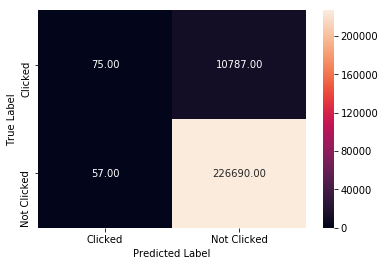

In [260]:
draw_cm(y_pred_df.actual, y_pred_df.predicted1)

In [261]:
print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted1))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    226747
           1       0.57      0.01      0.01     10862

    accuracy                           0.95    237609
   macro avg       0.76      0.50      0.50    237609
weighted avg       0.94      0.95      0.93    237609



We create the following function for drawing ROC curve.

In [262]:
def draw_roc(actual, probs):
    fpr,tpr,thresholds = metrics.roc_curve(actual,probs,drop_intermediate = False)
    
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure(figsize=(8,6))

    plt.plot(fpr,tpr,label='ROC curve( area = %0.2f)' %auc_score)

    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

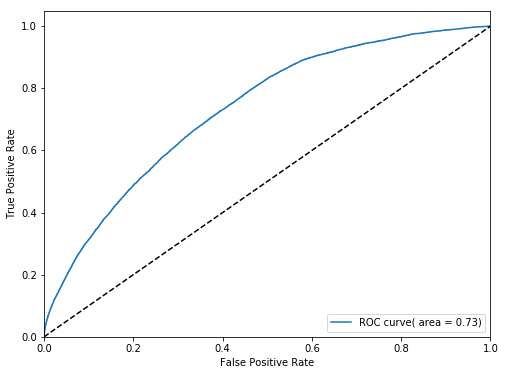

In [263]:
fpr, tpr, thresholds = draw_roc(y_pred_df.actual, y_pred_df.predicted_prob1)

In [264]:
tpr_fpr = pd.DataFrame({'tpr' : tpr, 'fpr' : fpr, 'thresholds' : thresholds })
tpr_fpr['diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values('diff', ascending = False)[0:5]

,tpr,fpr,thresholds,diff
113680,0.79617,0.463212,0.040101,0.332958
113681,0.79617,0.463217,0.040101,0.332953
113682,0.79617,0.463221,0.040100,0.332949
113683,0.79617,0.463226,0.040100,0.332945
113684,0.79617,0.463230,0.040100,0.332940


From the above results, we use the threshold as 0.040101. and draw the confusion matrix for the same.

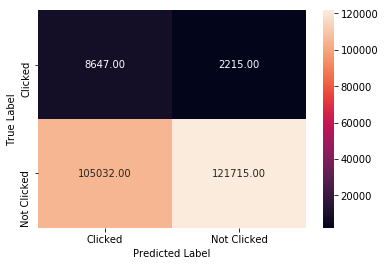

              precision    recall  f1-score   support

           0       0.98      0.54      0.69    226747
           1       0.08      0.80      0.14     10862

    accuracy                           0.55    237609
   macro avg       0.53      0.67      0.42    237609
weighted avg       0.94      0.55      0.67    237609



In [266]:
preicted_prob1 = logit1_model.predict(X1);

y_pred_df = pd.DataFrame({"actual": Y_train.is_click, "predicted_prob1": preicted_prob1})

y_pred_df['predicted1'] = y_pred_df.predicted_prob1.map(lambda x: 1 if x > 0.040101 else 0)

draw_cm(y_pred_df.actual, y_pred_df.predicted1)

print(metrics.classification_report(y_pred_df.actual, y_pred_df.predicted1))

## Below code is for generating file for submission

In [267]:
X_test = encoded_tr_item[encoded_tr_item.test_train_train==0];

In [268]:
preicted_prob1 = logit1_model.predict(sm.add_constant(X_test[sig_vars.Variable]));

y_pred_test_df = pd.DataFrame({"predicted_prob1": preicted_prob1})

y_pred_test_df['predicted1'] = y_pred_test_df.predicted_prob1.map(lambda x: 1 if x > 0.040226 else 0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [269]:
submit_csv = pd.DataFrame({"impression_id" : tr_item[tr_item.test_train=='test'].impression_id, 
                           "is_click" : y_pred_test_df.predicted1});

In [270]:
submit_csv.to_csv('nammaAnalytics10.csv');